In [24]:
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, classification_report, recall_score, f1_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate 
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
from numpy import mean
pd.set_option('display.max_colwidth', -1)
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns


In [32]:
df = pd.read_excel('1 выборка.xlsx')
df.shape

(2282, 24)

quite a high dim data

In [33]:
# prepare X and y

X = df.drop(['Наименование на английском','Банкрот', 'Регион', 'Кластер'],axis=1)
cols = X.columns

X = pd.DataFrame(X)
X.columns = cols

y = df['Банкрот']
y = pd.DataFrame(y)
y.columns = ['Банкрот']

In [4]:
Counter(y['Банкрот'])

Counter({0: 2253, 1: 29})

* 'bankrupt' class is coded as 1
* 'this is fine' class (not bankrupts) coded as 0

dataset is highly unbalanced (1:99) so I will use SMOTE algoritm with default settings, otherwise the models would just ignore minor class:
* split dataset into train (80%) and test (20%) sets
* generate new samples of minor class for training data to be balanced (whilte test set remains unchanged)

In [5]:
target_names = ['this is fine', 'bankrupt']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

### DECISION TREE

I would implement decision tree first to get some insights about whether there might be some more important features

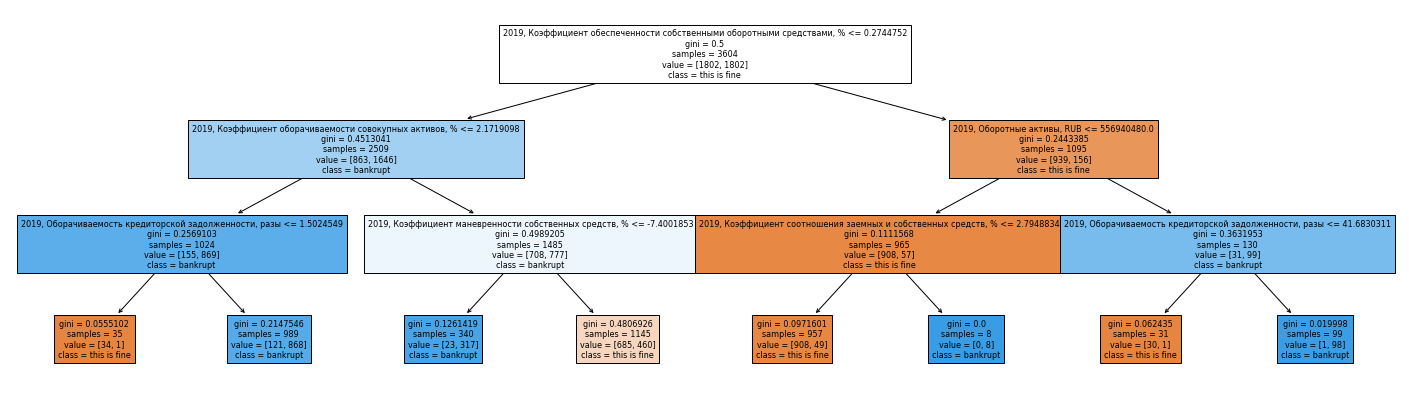

              precision    recall  f1-score   support

this is fine      0.990     0.905     0.946       451
    bankrupt      0.044     0.333     0.078         6

    accuracy                          0.897       457
   macro avg      0.517     0.619     0.512       457
weighted avg      0.978     0.897     0.934       457

[[408  43]
 [  4   2]]


In [7]:
clf = DecisionTreeClassifier(min_samples_leaf=5, max_depth=3)
clf.fit(X_train, y_train)

fig = plt.figure(figsize=(25, 7))
X.feature_names = X.columns

_ = tree.plot_tree(clf, filled=True, feature_names=X.feature_names, class_names=['this is fine', 'bankrupt'], fontsize=8, precision=7)
plt.show()
fig.savefig('tree.pdf')

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3, target_names=target_names))
print(confusion_matrix(y_test, y_pred))

Recall is very nice for both classes and what is more important: 4 out of 6 bankrupts are identified! The problem with decision tree here is that such a result is not stable. Cross validation was not implemented as I just wanted to get the most important features, this list is quite constant

I scale data since there are both absolute and rates values and rest of models is not able to handle unscaled data

In [8]:
scaler = MinMaxScaler()
scaler.fit(X)

X=scaler.transform(X)
X=pd.DataFrame(X)
X.columns = cols
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [9]:
def precision(conf):
    TP = conf[0, 0]
    FP = conf[0, 1]
    FN = conf[1, 0]
    TN = conf[1, 1]
    if (TP + FP) == 0:
        result = 0
    else:
        result = TP / (TP + FP)
    return round(result, 3)


def recall(conf):  # same as sensitivity
    TP = conf[0, 0]
    FP = conf[0, 1]
    FN = conf[1, 0]
    TN = conf[1, 1]
    if (TP + FN) == 0:
        result = 0
    else:    
        result = TP / (TP + FN)
    return round(result, 3)


def specificity(conf):
    TP = conf[0, 0]
    FP = conf[0, 1]
    FN = conf[1, 0]
    TN = conf[1, 1]
    if (TN + FP) == 0:
        result = 0
    else:    
        result = TN / (TN + FP)
    return round(result, 3)

### LOGISTIC REGRESSION

In [10]:
def sfs_compute(clf, X_train, y_train):
    for i in range(1,11):

        sfs = SequentialFeatureSelector(clf, n_features_to_select=i)
        sfs.fit(X_train, y_train)

        new_data = sfs.transform(X_train)

        clf.fit(new_data, y_train)

        new_test = sfs.transform(X_test)
        print('number of factors: ',i)
        print('accuracy: %.3f'% clf.score(new_test, y_test))
    
        y_pred = clf.predict(new_test)
        conf = confusion_matrix(y_test, y_pred)
    
    #print('accuracy: %.3f'% clf.score(new_test, y_test))
        print(conf)
        tn, fp, fn, tp = conf.ravel()
    
        accuracy_result = clf.score(new_test, y_test)
        accuracy_list.append(accuracy_result)
    
        tp_result = tp
        tp_list.append(tp_result)
        precision_result = precision(conf)
        precision_list.append(precision_result)
        recall_result = recall(conf)
        recall_list.append(recall_result)
        specificity_result = specificity(conf)
        specificity_list.append(specificity_result)
        print('')

In [11]:
accuracy_list = []
precision_list = []
specificity_list = []
recall_list = []
tp_list = []
clf = LogisticRegression(random_state=0)
    
sfs_compute(clf, X_train, y_train)

number of factors:  1
accuracy: 0.856
[[389  62]
 [  4   2]]

number of factors:  2
accuracy: 0.884
[[402  49]
 [  4   2]]

number of factors:  3
accuracy: 0.849
[[386  65]
 [  4   2]]

number of factors:  4
accuracy: 0.840
[[382  69]
 [  4   2]]

number of factors:  5
accuracy: 0.836
[[380  71]
 [  4   2]]

number of factors:  6
accuracy: 0.821
[[371  80]
 [  2   4]]

number of factors:  7
accuracy: 0.810
[[366  85]
 [  2   4]]

number of factors:  8
accuracy: 0.849
[[386  65]
 [  4   2]]

number of factors:  9
accuracy: 0.545
[[245 206]
 [  2   4]]

number of factors:  10
accuracy: 0.766
[[345 106]
 [  1   5]]



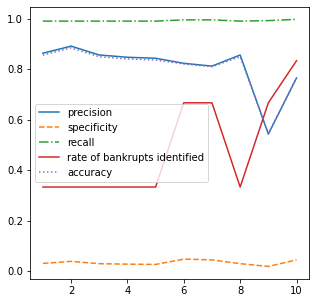

In [12]:
tp_plot = [x / 6 for x in tp_list]
number_of_leafs = list(range(1, 11))
# plot lines
font = {'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.figure(figsize=(5, 5))
plt.plot(number_of_leafs, precision_list, label="precision", linestyle="-")
plt.plot(number_of_leafs, specificity_list, label="specificity", linestyle="--")
plt.plot(number_of_leafs, recall_list, label="recall", linestyle="-.")
plt.plot(number_of_leafs, tp_plot, label="rate of bankrupts identified", linestyle="-")
plt.plot(number_of_leafs, accuracy_list, label="accuracy", linestyle=":")
plt.legend()
plt.show()

as seen on plot 6 features (out of 20) is optimal number for logistic regression, so I would figure out what are these features names

In [13]:
clf = LogisticRegression(random_state=0) #.fit(X, y)

sfs = SequentialFeatureSelector(clf, n_features_to_select=6)
sfs.fit(X_train, y_train)
cols = sfs.get_support(indices=True)
X_important_features = X_train.iloc[:,cols]

check the features for high multi-collinearity using VIF

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_important_features.columns
X_important_features = X_important_features.assign(const=1)

pd.Series([variance_inflation_factor(X_important_features.values, i) 
               for i in range(X_important_features.shape[1])], 
              index=X_important_features.columns)

2019, Оборачиваемость кредиторской задолженности, разы                    3.452334   
2019, Коэффициент оборачиваемости совокупных активов, %                   3.447450   
2019, Коэффициент соотношения заемных и собственных средств, %            1.000035   
2019, Коэффициент обеспеченности собственными оборотными средствами, %    1.002628   
2019, Рентабельность затрат, %                                            1.000684   
2019, Коэффициент текущей ликвидности, %                                  1.006404   
const                                                                     3842.761383
dtype: float64

there are 2 features which are a bit highly correlated, so I drop 1 of it

In [15]:
X_important_features = X_important_features.drop('2019, Оборачиваемость кредиторской задолженности, разы', axis=1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_important_features.columns
X_important_features = X_important_features.assign(const=1)

pd.Series([variance_inflation_factor(X_important_features.values, i) 
               for i in range(X_important_features.shape[1])], 
              index=X_important_features.columns)

2019, Коэффициент оборачиваемости совокупных активов, %                   1.000479   
2019, Коэффициент соотношения заемных и собственных средств, %            1.000026   
2019, Коэффициент обеспеченности собственными оборотными средствами, %    1.001074   
2019, Рентабельность затрат, %                                            1.000682   
2019, Коэффициент текущей ликвидности, %                                  1.000053   
const                                                                     3838.739918
dtype: float64

In [16]:
clf = LogisticRegression(random_state=0).fit(X_important_features, y_train)
feature_coef = pd.DataFrame(clf.coef_)
feature_coef.columns = X_important_features.columns
feature_coef.T

,0
"2019, Коэффициент оборачиваемости совокупных активов, %",-1.103110
"2019, Коэффициент соотношения заемных и собственных средств, %",1.390271
"2019, Коэффициент обеспеченности собственными оборотными средствами, %",-1.989842
"2019, Рентабельность затрат, %",-1.002229
"2019, Коэффициент текущей ликвидности, %",-0.398725
const,-0.000049


In [17]:
X_important_features = X_important_features.drop(['const'], axis=1)
X_test_important = X_test[X_important_features.columns]

In [18]:
clf = LogisticRegression(random_state=0).fit(X_important_features, y_train)
y_pred = clf.predict(X_test_important)
print(classification_report(y_test, y_pred, digits=3, target_names=target_names))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

this is fine      0.995     0.838     0.910       451
    bankrupt      0.052     0.667     0.096         6

    accuracy                          0.836       457
   macro avg      0.523     0.752     0.503       457
weighted avg      0.982     0.836     0.899       457

[[378  73]
 [  2   4]]


### SUPPORT VECTOR MACHINE
default parameters, same algorithm

In [19]:
clf = LinearSVC(max_iter=10000) 
accuracy_list = []
precision_list = []
specificity_list = []
recall_list = []
tp_list = []
sfs_compute(clf, X_train, y_train)

number of factors:  1
accuracy: 0.562
[[254 197]
 [  3   3]]

number of factors:  2
accuracy: 0.729
[[329 122]
 [  2   4]]

number of factors:  3
accuracy: 0.711
[[321 130]
 [  2   4]]

number of factors:  4
accuracy: 0.646
[[291 160]
 [  2   4]]

number of factors:  5
accuracy: 0.613
[[276 175]
 [  2   4]]

number of factors:  6
accuracy: 0.799
[[360  91]
 [  1   5]]

number of factors:  7
accuracy: 0.853
[[385  66]
 [  1   5]]

number of factors:  8
accuracy: 0.864
[[391  60]
 [  2   4]]

number of factors:  9
accuracy: 0.611
[[274 177]
 [  1   5]]

number of factors:  10
accuracy: 0.764
[[344 107]
 [  1   5]]



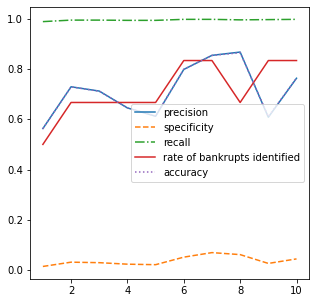

In [20]:
tp_plot = [x / 6 for x in tp_list]
number_of_leafs = list(range(1, 11))
# plot lines
font = {'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.figure(figsize=(5, 5))
plt.plot(number_of_leafs, precision_list, label="precision", linestyle="-")
plt.plot(number_of_leafs, specificity_list, label="specificity", linestyle="--")
plt.plot(number_of_leafs, recall_list, label="recall", linestyle="-.")
plt.plot(number_of_leafs, tp_plot, label="rate of bankrupts identified", linestyle="-")
plt.plot(number_of_leafs, accuracy_list, label="accuracy", linestyle=":")
plt.legend()
plt.show()

In [21]:
sfs = SequentialFeatureSelector(clf, n_features_to_select=7)
sfs.fit(X_train, y_train)
cols = sfs.get_support(indices=True)
important_features = pd.DataFrame(X_train.iloc[:,cols].columns)
important_features

,0
0,"2019, Собственный оборотный капитал, RUB"
1,"2019, Оборачиваемость кредиторской задолженности, разы"
2,"2019, Коэффициент оборачиваемости совокупных активов, %"
3,"2019, Коэффициент концентрации собственного капитала (автономии), %"
4,"2019, Коэффициент обеспеченности собственными оборотными средствами, %"
5,"2019, Рентабельность затрат, %"
6,"2019, Коэффициент текущей ликвидности, %"


In [22]:
clf = LinearSVC(max_iter=10000).fit(X_train[important_features[0]], y_train)
y_pred = clf.predict(X_test[important_features[0]])
print(classification_report(y_test, y_pred, digits=3, target_names=target_names))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

this is fine      0.997     0.851     0.919       451
    bankrupt      0.069     0.833     0.128         6

    accuracy                          0.851       457
   macro avg      0.533     0.842     0.523       457
weighted avg      0.985     0.851     0.908       457

[[384  67]
 [  1   5]]


Most of parameters are the same as with logistic regression, some of it intersect with decision tree, showing quite a good consistency of results, but due to train_test_split the coefficients might slightly change

implementing XGBoost & Random forest

In [31]:
#########################################################
# XGBOOST ###############################################
#########################################################
    
# default parameters
def XGBOOST_default(X_train, y_train, X_test, y_test):   

    D_train = xgb.DMatrix(X_train, label=y_train)
    D_test = xgb.DMatrix(X_test, label=y_test)
    param = {} 
    steps = 100  # The number of training iterations
    clf = xgb.train(param, D_train, steps)
    preds = clf.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    XGBoost_to_final_table(best_preds, y_test)

# randomized search
def XGBOOST_random_search(X_train, y_train, X_test, y_test):
    
    steps = 100  # The number of training iterations
    D_train = xgb.DMatrix(X_train, label=y_train)
    D_test = xgb.DMatrix(X_test, label=y_test)
    param = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [3, 4, 5, 6, 10, 50],
     "min_child_weight" : [1, 3, 5, 7],
     "gamma"            : [0.0, 0.1, 0.2, 0.3, 0.4],
     "colsample_bytree" : [0.3, 0.4, 0.5, 0.7],
     'verbosity': [0]
     }
    
    clf = xgb.XGBClassifier()
    XGB_random = RandomizedSearchCV(estimator = clf, 
                               param_distributions = param, n_iter = 50, 
                               cv = 3, random_state=42)
    XGB_random.fit(X_train, y_train)
    param = XGB_random.best_params_
    print('XGB_randomized_best: ', param)
    clf = xgb.train(param, D_train, steps)
    
    preds = clf.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    XGBoost_to_final_table(best_preds, y_test)
    
#########################################################
# RANDOM FOREST #########################################
#########################################################

# default parameters
def RF_default(X_train, y_train, X_test, y_test):    
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    add_to_final_table(X_test, y_test, clf)
    
# randomized search
def RF_random_search(X_train, y_train, X_test, y_test): 
    
    clf = RandomForestClassifier()
    random_grid = {'bootstrap': [True, False],
     'max_depth': [50, 100, 200],
     'min_samples_leaf': [5, 10, 20],
     'min_samples_split': [20, 40],
     'n_estimators': [500, 2000, 4000]}
    clf = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    clf.fit(X_train, y_train)
    print('Random_forest_best: ', clf.best_params_)
    add_to_final_table(X_test, y_test, clf)
    
target_names = ['здоровая компания', 'банкрот']

In [43]:
from sklearn.utils import resample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.columns = X.columns
df_train = pd.concat([X_train, y_train], axis=1)
#df_train.columns = colsdf
X_test.columns = cols
# Separate majority and minority classes
df_majority = df_train[df_train.Банкрот==0]
df_minority = df_train[df_train.Банкрот==1]
 
# Upsample minority class
df_downsampled = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=df_minority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_downsampled, df_minority])
 
# Display new class counts
df_upsampled.Банкрот.value_counts()
df_train = df_upsampled

y_train = df_train['Банкрот']
X_train = df_train.drop(['Банкрот'], axis=1)

In [48]:
XGBOOST_default(X_train, y_train, X_test, y_test)
XGBOOST_random_search(X_train, y_train, X_test, y_test)

XGB_randomized_best:  {'verbosity': 0, 'min_child_weight': 1, 'max_depth': 10, 'gamma': 0.4, 'eta': 0.1, 'colsample_bytree': 0.4}
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Random_forest_best:  {'n_estimators': 4000, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 100, 'bootstrap': True}


In [72]:
clf = RandomForestClassifier()
random_grid = {'bootstrap': [True, False],
     'max_depth': [50, 100, 200],
     'min_samples_leaf': [5, 10, 20],
     'min_samples_split': [20, 40],
     'n_estimators': [500, 2000, 4000]}
clf = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
clf.fit(X_train, y_train)
print('Random_forest_best: ', clf.best_params_)
print(classification_report(y_test, y_pred, digits=3, target_names=target_names))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Random_forest_best:  {'n_estimators': 500, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 50, 'bootstrap': True}
                   precision    recall  f1-score   support

здоровая компания      1.000     0.683     0.812       451
          банкрот      0.040     1.000     0.077         6

         accuracy                          0.687       457
        macro avg      0.520     0.841     0.445       457
     weighted avg      0.987     0.687     0.802       457



In [74]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
clf.feature_importances_

                   precision    recall  f1-score   support

здоровая компания      1.000     0.694     0.819       451
          банкрот      0.042     1.000     0.080         6

         accuracy                          0.698       457
        macro avg      0.521     0.847     0.450       457
     weighted avg      0.987     0.698     0.810       457

[[313 138]
 [  0   6]]


array([0.02918917, 0.05462313, 0.10032743, 0.03274617, 0.06609807,
       0.10824118, 0.04070613, 0.05198964, 0.02496916, 0.02635229,
       0.04499284, 0.02788515, 0.07620334, 0.02128181, 0.04241046,
       0.02535105, 0.09234528, 0.04751414, 0.03885362, 0.04791993])

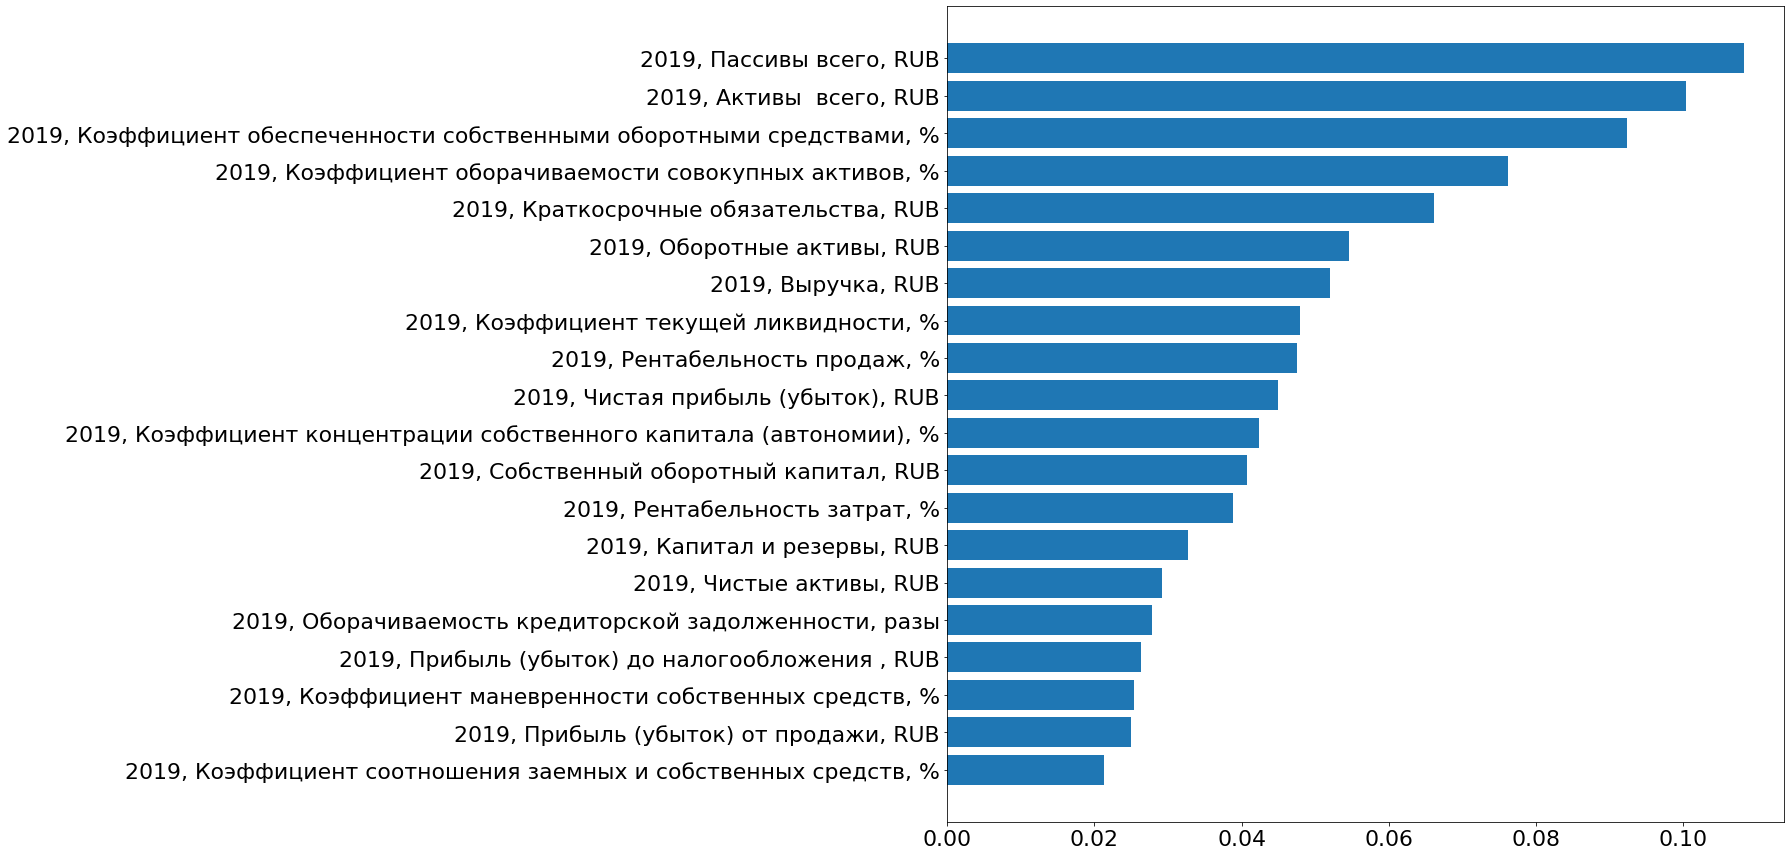

In [115]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams.update({'font.size': 22})

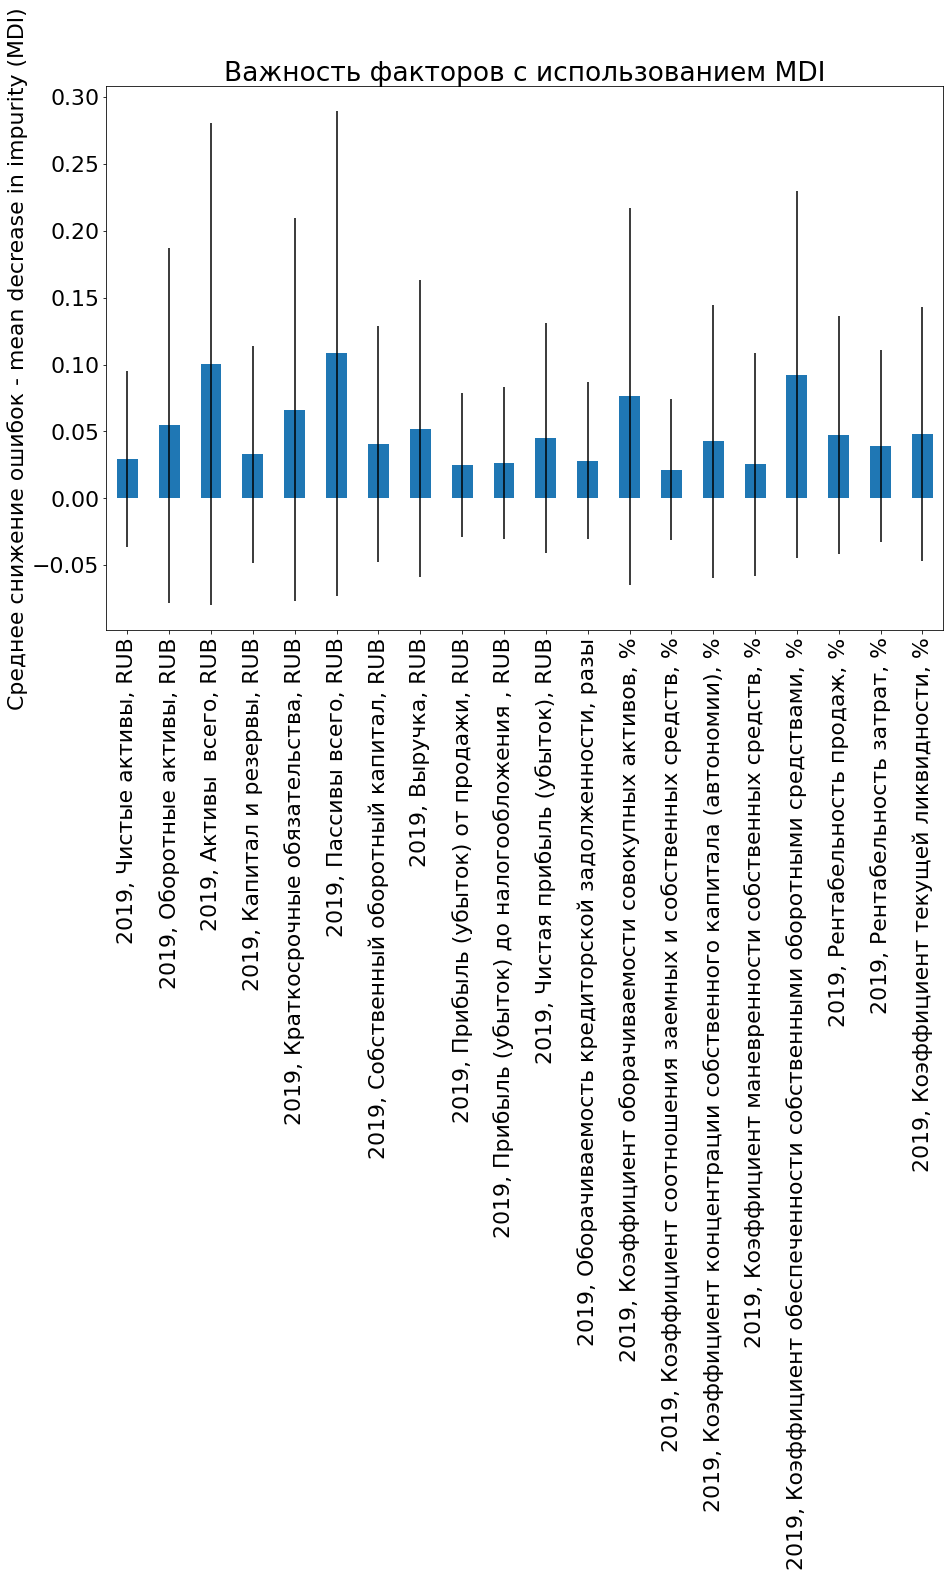

In [121]:
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Важность факторов с использованием MDI")
ax.set_ylabel("Среднее снижение ошибок - mean decrease in impurity (MDI)")
fig.tight_layout()

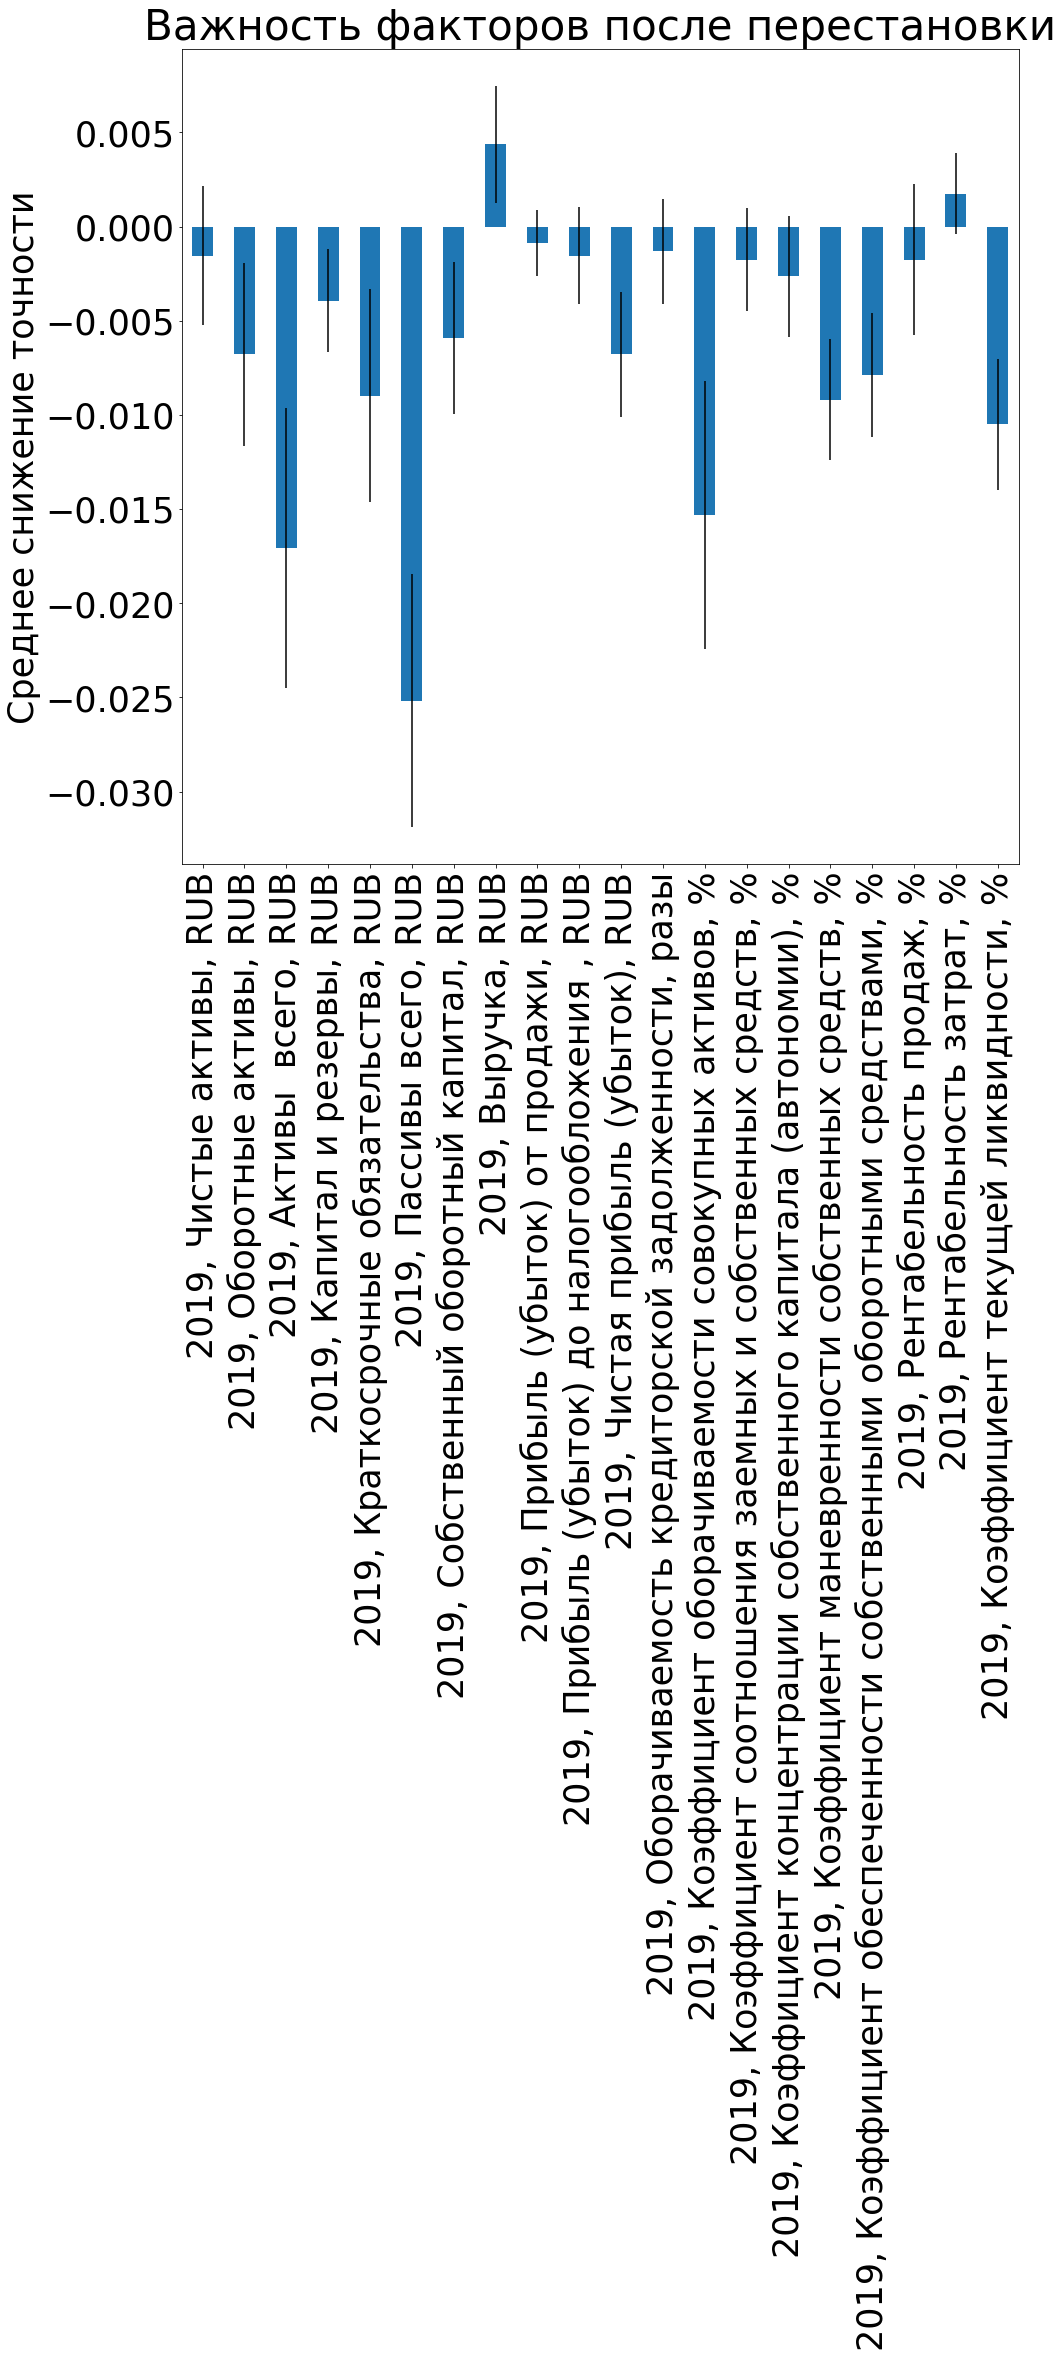

In [138]:
#https://scikit-learn.org/stable/modules/permutation_importance.html#id2
from sklearn.inspection import permutation_importance
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=X_train.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Важность факторов после перестановки")
ax.set_ylabel("Среднее снижение точности")
fig.tight_layout()
plt.rcParams.update({'font.size': 35})
plt.show()